# Project 2: Thermodynamics 

Annie Chu and Annie Tor

ModSim Studio 1

In [67]:
# import functions that will let us read .csv files
from pandas import read_csv

# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question: How does window thickness affect the temperature of a room over the course of a typical fall day in Boston?


The New England climate consists of hot summers and cold winters, so quality wall insulation is pretty important. One of the factors that determines the insulative capabilities of a wall is the thickness and material composition. Furthermore, many walls have windows, which also affects the insulative capabilities of the overall wall and how it affects the inside temperature of the building. So how does window thickness affect the temperature of a room over the course of a typical fall day in Boston?

## Methods

First, we'll read in our data. To calculate the hourly inside temperature, we needed to find the hourly outside temperature. We chose to take hourly temperature data from Logan International Airport in Boston, MA from October 18th, 2018. We assumed this day to be our "typical" fall day. We sourced this from Weather Underground.

In [73]:
filename = r'C:\Users\ator\Desktop\ModSim\Project2TempData.csv'
tables = read_csv(filename, header=0, index_col=0);

In making our system, we had to incorporate the dimensions of the total wall, the window, and the surrounding plaster. In addition, we added the R-values, or the ability of a material to insulate, and the specific heats, or the heat needed to raise the temperature of a unit of a material by one degree, of both the window and plaster. We found the area and volume of the plaster by defining the window and total wall dimensions first, then using the difference of the two to find the plaster area and volume. The units for dimensions were meters; the units for R values were (meters^2 * Kelvin)/Watts; the units for C values were kilojoules/(kilograms * Kelvin). We also included the density of the window and plaster. 

In [74]:
def make_system(w_len, w_wid, w_th, total_len, total_wid, pl_th, w_R, pl_R, w_C, pl_C, w_den, pl_den):
    init = State(temp_in = 291)
    t0 = 0
    t_end = 23
    dt = 1
    
    total_a = total_len * total_wid
    
    w_a = w_len * w_wid
    w_vol = w_a * w_th
    
    pl_a = total_a - w_a
    pl_vol = pl_a * pl_th
    
    return System(init=init, 
                  t0 = t0, 
                  t_end = t_end, 
                  dt = dt, 
                  total_a = total_a,
                  w_a = w_a,
                  w_vol = w_vol,
                  pl_a = pl_a,
                  pl_vol = pl_vol,
                  w_len = w_len,
                  w_wid = w_wid,
                  w_th = w_th,
                  total_len = total_len,
                  total_wid = total_wid,
                  pl_th = pl_th,
                  w_R = w_R,
                  pl_R = pl_R, 
                  w_C = w_C,
                  pl_C = pl_C, 
                  w_den = w_den, 
                  pl_den = pl_den)

Our differential equation for the change in indoor temperature over time was derived from three separate equations. We calculated the change for plaster and window separately. First, we calculated the individual heat flow rates in J/s over the plaster and the window using the equation dH/dt = (A * (Tout - Tin))/R. Next, we needed to convert our differential heat equation into a differential temperature equation. This was done by combining the specific heat equation and density equation. The final equation was dT/dt = (1000 * Area * (Tout-Tin))/ (3600 * R * C * Density * Area * Thickness), which outputed Kelvin/hours. The equation was modified to convert the units from kJ to joules and seconds to hours, which is why it was multiplied by 1000 and divided by 3600. After calculating dT/dt for the plaster and window individually, the indoor temperature was found by adding the two differentials, which were then multiplied by the time step, dt, to find the total temperature change, which was then added to the previous indoor temperature value. 

In [75]:
def update_func(state, t, system):
    Temp_in = state.temp_in
    
    delt_temp = tables.Temp[t] - Temp_in
    
    unpack(system)

    dTdt_plaster = 1000 * ((pl_a * delt_temp) / (3600 * pl_R * pl_C * pl_den * pl_a * pl_th))
    dTdt_window =  1000 * ((w_a * delt_temp) / (3600 * w_R * w_C * w_den * w_a * w_th))
    
    Temp_in += (dTdt_plaster +  dTdt_window) * dt

    return State(temp_in=Temp_in)

Next, we created a TimeSeries for the indoor temperature change over 24 hours. The initial indoor temperature was defined in making the system as 291 Kelvin, which is roughly equivalent to 65 degrees Fahrenheit and a typical indoor temperature. Every time step was incremented by the given dt, which was one hour, and was therefore assessed at every hour.  

In [76]:
def run_simulation(system, update_func):
    unpack(system)
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
              
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    return frame

Our sweep_thickness function swept the thicknesses of the window. For every thickness, we made a new system, evaluated it using run_simulation, and added it to our SweepSeries, sweep.

In [77]:
def sweep_thickness(w_len, w_wid, w_th, total_len, total_wid, pl_th, w_R, pl_R, w_C, pl_C, w_den, pl_den):
    sweep = SweepSeries()
    for w_th in w_thicknesses:
        system = make_system(w_len, w_wid, w_th, total_len, total_wid, pl_th, w_R, pl_R, w_C, pl_C, w_den, pl_den)
        results = run_simulation(system, update_func)
        sweep[system.w_th] = results
    return sweep

We determined the thicknesses of the window using an array of 11 values ranging from 0.01 to 0.1. We did not use linspace because the spacing was not always exact, i.e. 0.04 was really 0.04000000001, making it difficult to call the specific value in other functions. 

In [64]:
w_thicknesses = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

Next, we implemented our sweep_thickness function using the array of our window thicknesses from earlier. The R and C values used for plaster and glass were found online via Engineering Toolbox and Colorado Energy.

In [78]:
sweep = sweep_thickness(0.5, 0.5, w_thicknesses, 3, 3, 0.25, 0.91, 5, 0.84, 1, 2600, 849);

## Results

Finally, we plotted our different window thicknesses and their corresponding indoor temperature values over a day. Python tends to plot DataFrames individually, so we found a way to plot all our results on the same graph, shown below. We used a for loop to plot each thickness value on the graph. 

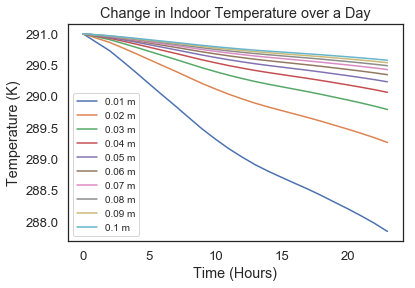

In [72]:
ax = sweep[0.01].plot(title = 'Change in Indoor Temperature over a Day')
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Temperature (K)')
for th in w_thicknesses[1:]:
    sweep[th].plot(ax=ax)
    plt.legend([str(0.01) + ' m', str(0.02)+ ' m', str(0.03)+ ' m', str(0.04)+ ' m', str(0.05)+ ' m', str(0.06)+ ' m', str(0.07)+ ' m', str(0.08)+ ' m', str(0.09)+ ' m', str(0.1)+ ' m'], prop={'size': 10})

## Interpretation

Our graph shows that rooms with thicker windows experience significantly less temperature change than rooms with thinner windows. This indicates that change in indoor temperature decreases as window thickness increases. Interestingly, it appears that indoor temperature and window thickness aren’t linked linearly -- for every 0.01 meter increase in window thickness, the fluctuation of indoor temperature decreases less and less; the temperature range indoors is smaller. 

That being said, our model makes a lot of assumptions. In order to factor out the effect of the Sun on heat coming into the room, we’ve made our window completely North-facing (away from the Sun). This limits the scope of the model as North-facing windows account for only a fraction of all windows and it is unlikely that a window is completely North-facing. Additionally, we assume that the ceiling, floor, and other walls of the room will not have an impact on room temperature. In a normal structure, this would be highly unlikely. Furthermore, we assume there is no thermal interaction between the window and plaster. Lastly, we assume that there are no other sources or sinks of heat in the room. Again, a structure like this is highly improbable, as a room will usually be populated with other bodies and systems that will affect heat flow.

If we were to continue working on this model, we would try to test different window and wall materials, which would entail introducing different R and C values, specific heats, and densities. Additionally, we would try to test different wall orientations. In order to do this, we’d need to find the position of the Sun at any time, as well as find out how solar energy interacts with windows in order to be converted to heat energy. We may also incorporate having multiple windows rather than a singular one into the model. 

While this model in particular may not be usable in most construction or architecture applications, we believe that it could provide a useful base on which to build more complex and accurate models. 
